# Extract regional dataset from HydroSHEDS

In this notebook the regional dataset is extracted from the HydroSHEDS dataset.
The countries combined are: India, Bangladesh, China Xizang, Butan en Nepal.

In [ ]:
import geopandas as gp
import pandas as pd
import time
from matplotlib import pyplot as plt
from descartes import PolygonPatch

In [2]:
water = gp.read_file('as_riv_15s/as_riv_15s.shp')
#water = water.set_index('ARCID')

Create spatial index

In [3]:
start = time.time()
water_index = water.sindex
end = time.time()
print(end - start)

98.75945281982422


## Combining regions

In [2]:
ind = gp.read_file('adm regions/IND_adm/IND_adm0.shp')

In [3]:
bgd = gp.read_file('adm regions/BGD_adm/BGD_adm0.shp')

In [4]:
chn = gp.read_file('adm regions/CHN_adm/CHN_adm0.shp')
chnprov = gp.read_file('adm regions/CHN_adm/CHN_adm1.shp')
#chnprov = chnprov[chnprov['NAME_1']=='Xizang' ]

In [5]:
btn = gp.read_file('adm regions/BTN_adm/BTN_adm0.shp')

In [6]:
npl = gp.read_file('adm regions/NPL_adm/NPL_adm0.shp')

In [7]:
chn

,ID_0,ISO,NAME_0,OBJECTID_1,ISO3,NAME_ENGLI,NAME_ISO,NAME_FAO,NAME_LOCAL,NAME_OBSOL,...,CARICOM,EU,CAN,ACP,Landlocked,AOSIS,SIDS,Islands,LDC,geometry
0,49,CHN,China,45,CHN,China,CHINA,China,Zhong Guo,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,(POLYGON ((109.6765289306645 18.18708419799833...


In [8]:
chn.loc[[0],'geometry'] = chnprov.loc[[28],'geometry'].values

In [9]:
regions = pd.concat([ind,bgd,chn,btn,npl])

In [10]:
regions.to_file('adm regions/combined.shp')

In [12]:
regions_area = regions.convex_hull

In [13]:
regions.boundary

0    (LINESTRING (93.78772735595709 6.8526401519778...
0    (LINESTRING (92.27416992187494 20.926111221313...
0    (LINESTRING (88.91962432861351 27.322996139526...
0    LINESTRING (89.80424499511724 28.2388420104981...
0    LINESTRING (81.7145156860351 30.41273307800293...
dtype: object

Create single shape:

In [14]:
region = regions.unary_union

## Finding edges in square region

In [15]:
possible_matches_index = list(water_index.intersection(region.bounds))
possible_matches = water.iloc[possible_matches_index]
#precise_matches = possible_matches[possible_matches.intersects(region)]

In [16]:
possible_matches.to_file("out/water_in_region_box.shp")

## Precise finding edges

First step is to divide the shape into squares.

In [17]:
west, south, east, north = region.bounds

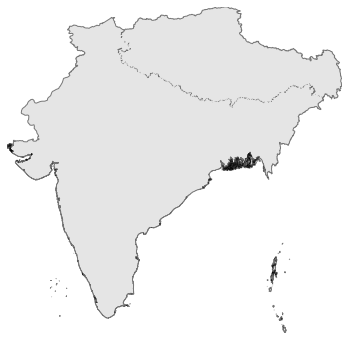

In [18]:
fig, ax = plt.subplots(figsize=(6,6))
for polygon in region:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.5, zorder=2)
    ax.add_patch(patch)

ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()

In [19]:
import osmnx as ox

In [20]:
geometry_cut = ox.quadrat_cut_geometry(region, quadrat_width=1)

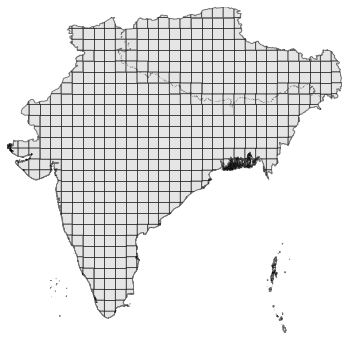

In [21]:
fig, ax = plt.subplots(figsize=(6,6))
for polygon in geometry_cut:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.5, zorder=2)
    ax.add_patch(patch)
    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()

To speed up calculation, first the matches for each square cut are found.
Then for each of those matches it is determined if the are in the shapeform.

In [22]:
# find the points that intersect with each subpolygon and add them to points_within_geometry
sindex = water_index
points_within_geometry = pd.DataFrame()
i=0
for poly in geometry_cut:
    # buffer by the <1 micron dist to account for any space lost in the quadrat cutting
    # otherwise may miss point(s) that lay directly on quadrat line
    poly = poly.buffer(1e-14).buffer(0)

    # find approximate matches with r-tree, then precise matches from those approximate ones
    possible_matches_index = list(sindex.intersection(poly.bounds))
    possible_matches = water.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(poly)]
    points_within_geometry = points_within_geometry.append(precise_matches)
    
    i=i+1
    print("{:.0%}".format(i/len(geometry_cut)),end="\r")

In [23]:
points_within_geometry.head()

,ARCID,UP_CELLS,geometry
623842,623843,172,LINESTRING (79.16249999999965 32.1041666666659...
623360,623361,4207,LINESTRING (79.15208333333298 32.1354166666659...
623076,623077,108,LINESTRING (79.21458333333298 32.1499999999993...
622498,622499,6122,LINESTRING (79.19374999999964 32.1895833333326...
622497,622498,141,LINESTRING (79.17083333333298 32.1958333333326...


In [24]:
points_within_geometry.shape

(137124, 3)

In [25]:
# drop duplicate points, if buffered poly caused an overlap on point(s) that lay directly on a quadrat line
points_within_geometry = points_within_geometry.drop_duplicates(subset=['ARCID'])
points_outside_geometry = water[~water.isin(points_within_geometry)]

In [26]:
points_within_geometry.shape

(128150, 3)

Save the lines within the geometry

In [27]:
points_within_geometry.to_file("out/water_in_region.shp")

Plot lines within or outside the geometry

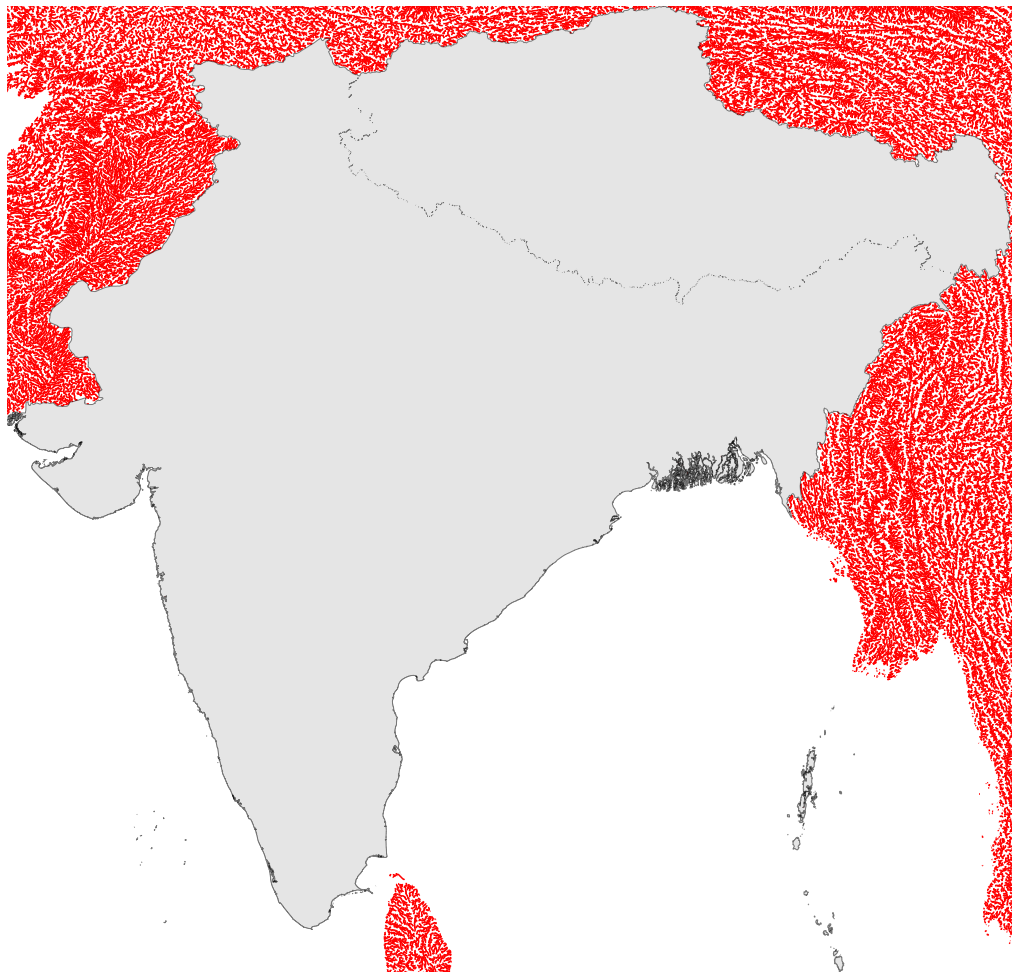

In [28]:
fig, ax = plt.subplots(1, figsize=(18,18))
for polygon in region:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.5, zorder=2)
    ax.add_patch(patch)

#points_within_geometry.plot(ax=ax,color='b')
points_outside_geometry.plot(ax=ax,color='r')

ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()